# A 1-qubit classifier

In [1]:
import math
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, BasicAer, Aer
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_bloch_multivector

In [2]:
def k2vec(k, m=4):
    """
        Parameters: 
            - k (integer) the integer number for the corresponding binary vector
            - m (integer) the length of binary string (needed to distinguish all possibilities)
        Returns: 
            - v (list) a binary vector correspoding to integer k 
        
        Description: By taking a fixed total ordering of binary strings of fixed length we
        can associate each binary vector with an integer. The integer is converted to a 
        binary string which can be used to generate unique vectors.
    """
    
    v = -1*np.ones(m)
    binary_string = ("{:0%db}"%m).format(k) # convert k to an m-digit binary number
    #print(binary_string)
    v = list(map(lambda v, b : v**int(b), v, binary_string)) 
    
    return v

def draw_state_vector(circ):
    """
        Input: 
            - circ (qiskit.circuit.quantumcircuit.QuantumCircuit) quantum circuit 
              to be executed
        Description:
            - Runs the quantum circuit and prints the resulting quantum state vector 
              and draws the circuit.
    """
    
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    output_state = result.get_statevector(circ, decimals=3)
    print("state vector after circuit:", output_state)
    print(circ.draw())

## All possible 2 bit boolean vectors with elements {-1, 1}

In [17]:
# generate all 2-bit boolean data
data = [k2vec(i,2) for i in range(4)]
for d in data:
    print(d)

[1.0, 1.0]
[1.0, -1.0]
[-1.0, 1.0]
[-1.0, -1.0]


## Create a dictionary with the circuits to encode the inputs and weights

In [4]:
k_circ = {}

In [5]:
# encodes k=0
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'c')
circ = QuantumCircuit(q, c)

# add to dictionary
k_circ[0] = circ

In [6]:
# encodes k=1
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'c')
circ = QuantumCircuit(q, c)

i = k2vec(1, 2)

print("i:", i)
#circ.h(q[0]) # uncomment to see that this is the correct circuit
circ.z(q[0])
draw_state_vector(circ)

# add to dictionary
k_circ[1] = circ

i: [1.0, -1.0]
state vector after circuit: [1.+0.j 0.+0.j]
        ┌───┐
q_0: |0>┤ Z ├
        └───┘
 c_0: 0 ═════
             


In [7]:
# encodes k=2
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'c')
circ = QuantumCircuit(q, c)

i = k2vec(2, 2)

print("i:", i)
#circ.h(q[0]) # uncomment to see that this is the correct circuit
circ.z(q[0])
circ.x(q[0])

draw_state_vector(circ)


# add to dictionary
k_circ[2] = circ

i: [-1.0, 1.0]
state vector after circuit: [0.+0.j 1.+0.j]
        ┌───┐┌───┐
q_0: |0>┤ Z ├┤ X ├
        └───┘└───┘
 c_0: 0 ══════════
                  


In [8]:
# encodes k=3
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'c')
circ = QuantumCircuit(q, c)

i = k2vec(3, 2)

print("i:", i)
#circ.h(q[0]) # uncomment to see that this is the correct circuit
circ.z(q[0])
circ.x(q[0])
circ.z(q[0])

draw_state_vector(circ)

# add to dictionary
k_circ[3] = circ

i: [-1.0, -1.0]
state vector after circuit: [ 0.+0.j -1.+0.j]
        ┌───┐┌───┐┌───┐
q_0: |0>┤ Z ├┤ X ├┤ Z ├
        └───┘└───┘└───┘
 c_0: 0 ═══════════════
                       


## Taking the inner product
We do this in a similar fashion to part 2. First create a superposition, then encode the inputs and weights, finally rotate the quantum state vector in such a way that the inner product information is contained in the amplitude for the |1> outcome.
<br><br>
One change from the previous classifier is that the ancillary qubit is no longer needed, as the inner product infromation is contained in $\beta$ as defined below, which directly determines the probability of a |1> measurement outcome.

$$\Psi = \alpha |0> + \beta |1>$$


In [9]:
def one_qubit_classifier(k_i, k_w, k_circ_dict):
    q = QuantumRegister(1, 'q')
    c = ClassicalRegister(1, 'c')
    circ = QuantumCircuit(q, c)

    circ.h(q[0])
    # encode i
    circ += k_circ_dict[k_i]
    # encode w
    circ += k_circ_dict[k_w]
    # rotation
    circ.h(q[0])
    circ.x(q[0])
    # measure
    circ.measure(q[0],c[0])
    
    print(circ)
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circ, simulator, shots=1024).result()
    counts = result.get_counts(circ)
    
    return counts

In [10]:
outcomes = np.zeros((4,4))

for m in range(4):
    i = k2vec(m)
    for n in range(4):
        w =  k2vec(n)
        counts  = one_qubit_classifier(m, n, k_circ)
        #print(counts)
        if len(counts) == 1:
            outcomes[m][n] = int([*counts][0]) # unpacking
        else:
            outcomes[m][n] = counts['1']/float(1024)


        ┌───┐┌───┐┌───┐┌─┐
q_0: |0>┤ H ├┤ H ├┤ X ├┤M├
        └───┘└───┘└───┘└╥┘
 c_0: 0 ════════════════╩═
                          
        ┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: |0>┤ H ├┤ Z ├┤ H ├┤ X ├┤M├
        └───┘└───┘└───┘└───┘└╥┘
 c_0: 0 ═════════════════════╩═
                               
        ┌───┐┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: |0>┤ H ├┤ Z ├┤ X ├┤ H ├┤ X ├┤M├
        └───┘└───┘└───┘└───┘└───┘└╥┘
 c_0: 0 ══════════════════════════╩═
                                    
        ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: |0>┤ H ├┤ Z ├┤ X ├┤ Z ├┤ H ├┤ X ├┤M├
        └───┘└───┘└───┘└───┘└───┘└───┘└╥┘
 c_0: 0 ═══════════════════════════════╩═
                                         
        ┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: |0>┤ H ├┤ Z ├┤ H ├┤ X ├┤M├
        └───┘└───┘└───┘└───┘└╥┘
 c_0: 0 ═════════════════════╩═
                               
        ┌───┐┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: |0>┤ H ├┤ Z ├┤ Z ├┤ H ├┤ X ├┤M├
        └───┘└───┘└───┘└───┘└───┘└╥┘
 c_0: 0 ══════════════════════════╩═
  

[[1. 0. 0. 1.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [1. 0. 0. 1.]]


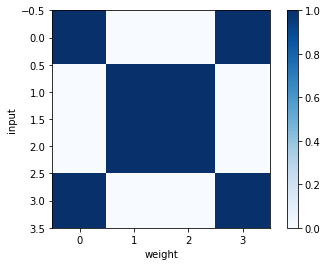

In [11]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
#ax.matshow(outcomes, cmap=plt.cm.Blues)
ax.set_xlabel("weight")
ax.set_ylabel("input")

out_plot = ax.imshow(outcomes, cmap='Blues', interpolation='none')
fig.colorbar(out_plot, ax=ax)

#fig.savefig('one-qubit-perceptron.png')

print(outcomes)

I think the one qubit example most clearly illustrates the differences between the classical and quantum perceptron algorithm. We see the ability of quantum hardware to encode $m=2^n$ bits of classical information on m qubits. We also see how this algorithm does not make the distinction between a pattern and it's negative due to the insiginficance of global phase ($\psi = -\psi$). This is an oddity, but may come in handy in learning the infamous boolean XOR data set.